Tome un conjunto de manzanas, un conjunto de peras, un conjunto de bananos y
un conjunto de fresas. Desarrolle un sistema clasificador de estas cuatro frutas, de manera que después de entrenar la red se le den imágenes de frutas de internet y el sistema las clasifique.

In [22]:
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os

1. Montar Google Drive


2. Configurar las rutas de las carpetas de datos

Aquí, establecemos las rutas de las carpetas que contienen los conjuntos de entrenamiento y prueba en Google Drive.

In [11]:
# Monta Google Drive
drive.mount('/content/drive')

# Rutas de las carpetas de datos en Google Drive
base_path = "/content/drive/MyDrive/Colab Notebooks/RNN_Fruits/"

train_dir = base_path + 'Training'
test_dir = base_path + 'Test'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3. Configurar Generador de imágenes.

Estas líneas configuran los generadores de imágenes para el conjunto de entrenamiento y prueba. La normalización rescale=1./255 escala los valores de píxeles a un rango de 0 a 1.

In [13]:
# Configura el generador de imágenes
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


4. Cargar y preprocesar imágenes.

Estos bloques utilizan flow_from_directory para cargar y preprocesar las imágenes de los directorios de entrenamiento y prueba, adecuando al tamaño de evaluación de 150 x 150 píxeles, clasificando en categorías de acuerdo con el título de cada subcarpeta en el directorio.

In [14]:

# Carga las imágenes de los directorios y aplica el preprocesamiento
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical'
)

Found 1955 images belonging to 4 classes.


In [15]:
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=32, class_mode='categorical'
)

Found 658 images belonging to 4 classes.


5. Construir el modelo de red neuronal

Aquí, utilizamos la arquitectura InceptionV3 como base del modelo, congelamos sus pesos y agregamos capas adicionales para la clasificación.

InceptionV3 es una arquitectura de red neuronal convolucional (CNN) que ha demostrado ser efectiva en tareas de clasificación de imágenes. Esta arquitectura fue propuesta por Google en 2015 y es conocida por su complejidad y eficacia. La característica clave de InceptionV3 es el uso de módulos de "inception", que son bloques que contienen diferentes tamaños de convoluciones (1x1, 3x3, 5x5) y operaciones de pooling. Estos módulos permiten que la red capture patrones a diferentes escalas espaciales, mejorando así la representación de las características.

* base_model base_model: Esta variable almacena la arquitectura de la red neural InceptionV3. Se utiliza como base para tu modelo de clasificación de frutas.
* La opción include_top=False indica que no se incluirá la capa densa de clasificación original de InceptionV3, ya que se agregará una capa propia  al final.

In [16]:

# Construir el modelo
base_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 clases de frutas
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


87910968/87910968 [==============================] - 1s 0us/step


6. Entrenar el modelo

Este bloque de código entrena el modelo utilizando el generador de imágenes de entrenamiento y valida con el generador de imágenes de prueba.

Entrenar un modelo implica ajustar los pesos de sus parámetros para que pueda realizar una tarea específica. En el contexto de redes neuronales, este proceso generalmente implica el uso de un conjunto de datos de entrenamiento etiquetado. Durante el entrenamiento, la red se ajusta iterativamente a los datos para minimizar una función de pérdida. En este caso, se utiliza el optimizador Adam y la función de pérdida categórica entropía cruzada para entrenar la red en la tarea de clasificación de frutas.

El modelo pasa por las imágenes de entrenamiento, calcula la pérdida entre las predicciones y las etiquetas reales, y ajusta los pesos utilizando el optimizador para minimizar esta pérdida.

Variables relevantes:


 * model: Representa tu modelo completo, que incluye la base InceptionV3 y las capas adicionales agregadas para la clasificación de frutas.
 * train_generator: Es un generador de imágenes que proporciona lotes de datos de entrenamiento junto con sus etiquetas durante el entrenamiento.
* epochs=n: Especifica el número de veces que el modelo pasará por todo el conjunto de entrenamiento durante el entrenamiento. Se harán solo 5 para evitar sobreentrenamiento

In [19]:

# Entrenar el modelo
history = model.fit(train_generator, epochs=5, validation_data=test_generator)


Epoch 1/5
62/62 [==============================] - 138s 2s/step - loss: 1.6769e-05 - accuracy: 1.0000 - val_loss: 0.0221 - val_accuracy: 0.9863
Epoch 2/5
62/62 [==============================] - 137s 2s/step - loss: 1.5224e-05 - accuracy: 1.0000 - val_loss: 0.0216 - val_accuracy: 0.9863
Epoch 3/5
62/62 [==============================] - 136s 2s/step - loss: 1.3920e-05 - accuracy: 1.0000 - val_loss: 0.0214 - val_accuracy: 0.9863
Epoch 4/5
62/62 [==============================] - 128s 2s/step - loss: 1.2872e-05 - accuracy: 1.0000 - val_loss: 0.0211 - val_accuracy: 0.9863
Epoch 5/5
62/62 [==============================] - 133s 2s/step - loss: 1.2045e-05 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 0.9878


7. Evaluar el modelo

Este bloque de código entrena el modelo utilizando el generador de imágenes de entrenamiento y valida con el generador de imágenes de prueba.

Después de entrenar el modelo, es crucial evaluar su rendimiento en un conjunto de datos que no se utilizó durante el entrenamiento, llamado conjunto de prueba. Esto ayuda a determinar cómo se generaliza el modelo a datos no vistos. En este caso, se utiliza el conjunto de prueba para evaluar la precisión del modelo.

La función evaluate calcula la pérdida y la precisión del modelo en el conjunto de prueba. Una precisión más alta indica un mejor rendimiento del modelo en la clasificación de nuevas imágenes no vistas durante el entrenamiento.

Variables relevantes:
* test_generator: Es un generador de imágenes que proporciona lotes de datos de prueba junto con sus etiquetas durante la evaluación.
* model.evaluate: Calcula la pérdida y la precisión del modelo en el conjunto de prueba.

In [20]:

# Evaluar el modelo
test_loss, test_acc = model.evaluate(test_generator)
print(f'Accuracy: {test_acc}')


21/21 [==============================] - 31s 1s/step - loss: 0.0198 - accuracy: 0.9878
Accuracy: 0.9878419637680054


8. Visualizar gráficos de precisión y pérdida durante el entrenamiento

Estos bloques generan gráficos para visualizar la precisión y la pérdida durante el entrenamiento, de esta forma se puede apreciar que tan efectivo es el modelo para realizar el trabajo de clasificación.

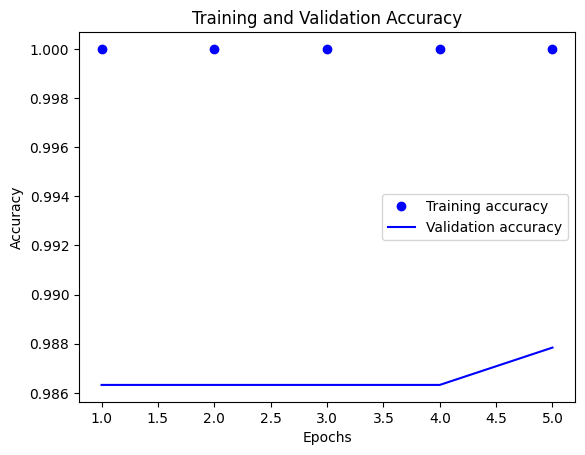

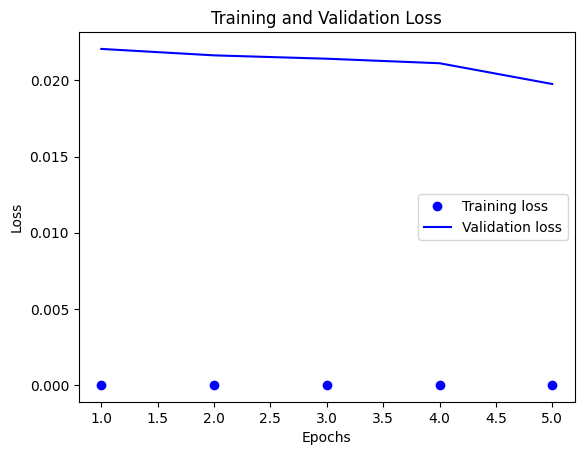

In [23]:

# Obtén la información de entrenamiento del objeto history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Número de épocas
epochs = range(1, len(accuracy) + 1)

# Gráfico de Precisión
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Gráfico de Pérdida
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


9. Clasificar nuevas imágenes.

La función classify_image utiliza el modelo entrenado para clasificar nuevas imágenes.

In [24]:

# Clasificar nuevas imágenes
def classify_image(image_path):
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    return predicted_class